# Score Matching

This section is about learning a score function from data using a neural network.
We will not yet address the notion of sampling from the SBM, 
which is covered in the next section on [diffusion](./03-diffusion.ipynb). 

## Naive Score Matching

Constructing a loss function for score matching is rather straight forward. The procedure was first described 
by [Aapo Hyvärinen in 2005](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf). 
Suppose $\mathbf{s}_\theta: \mathbb{R}^n \rightarrow \mathbb{R}^n$ is a neural network with parameters $\theta$. This network 
can be trained to match a score function by minimizing the mean squared error loss function

$$
    \mathcal{L}_\theta = \mathbb{E}_{p(\mathbf{x})} 
    \bigg[\big\lVert \mathbf{s}_\theta(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \big\rVert^2_2 \bigg] \, .
$$

This construction is naive because it assumes we have access to the ground truth score, $\nabla_{\mathbf{x}} \log p(\mathbf{x})$. Naturally, there would be no need to train a neural network if we did. This is why [Hyvärinen (2005)](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf) derived an equivalent loss 
function which abstracts away the ground truth score. His work eventually led Yang Song to build the Sliced Score Matching (SSM) loss function ([Song et al. (2019)](https://arxiv.org/abs/1905.07088)) using the Hutchinson trace estimator to speed up the Hessian trace in Hyvärinen's loss function. Instead of the SSM loss function, we will focus on the naive score matching approach to demonstrate some of its pitfalls &mdash; which the SSM also inherited. 
As it turns out, score matching is not straightforward even when given perfect information about the ground truth score.

We will build score matching from scratch to showcase the internals of the score models package. The stuff relevant to score matching done in this notebook are abstracted in the package. 
You can find these routines in the [Getting Started](./00-Overview.md) page.

In [1]:
!pip install --quiet score_models colorcet SciencePlots tqdm # For colab notebooks.
from score_models.plot_utils import *
from score_models.toy_distributions import *
from torch.func import grad, vmap
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


### Score model with signature $\mathbf{s}_\theta: \mathbb{R}^n \rightarrow \mathbb{R}^n$

In [2]:
class SBM(nn.Module):
    def __init__(self, n, depth=2, width=100):
        super().__init__()
        self.n = n
        module_list = [nn.Linear(n, width)]
        for i in range(depth):
            module_list.append(nn.Linear(width, width))
        self.output_layer = nn.Linear(width, n)
        self.layers = nn.ModuleList(module_list)
    
    def forward(self, x):
        for layer in self.layers:
            x = F.silu(layer(x))
        x = self.output_layer(x)
        return x

### Ground-truth score function


In [3]:
distribution = egg_box(4, mode_width=0.1, box_size=1)
# distribution = two_moons()
# distribution = swiss_roll()

def logp(x):
    return distribution.log_prob(x)

def score(x):
    return vmap(grad(logp))(x)

### Training the SBM

In [4]:
def naive_score_matching_loss(x, sbm):
    return ((score(x) - sbm(x))**2).flatten(1).sum(1).mean()

In [5]:
N = int(2e3)  # Number of iterations
B = int(2**8) # Batch size
net = SBM(2)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for i in tqdm(range(N)):
    x = distribution.sample((B,))               # x ~ p(x)
    loss = naive_score_matching_loss(x, net)    # loss = E_x [||∇log p(x) - s_θ(x)||^2]
    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

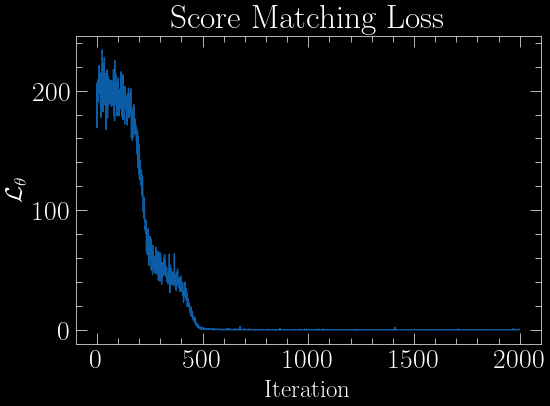

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title("Score Matching Loss")
plt.ylabel(r"$\mathcal{L}_\theta$")
plt.xlabel("Iteration");

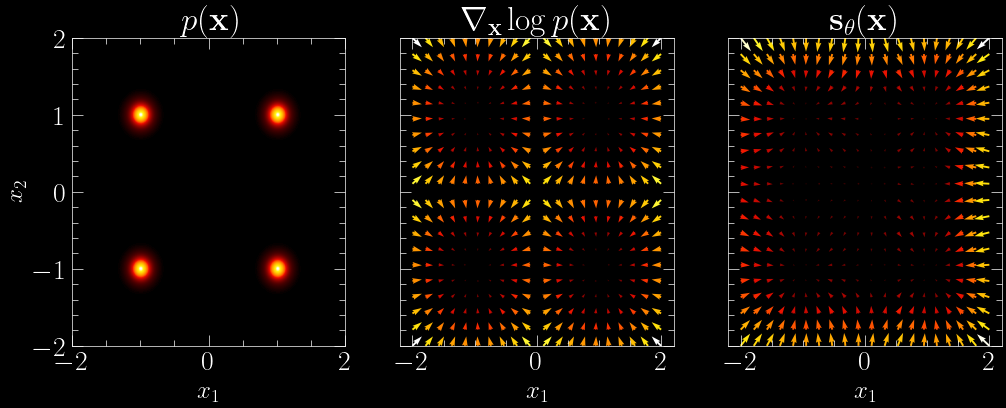

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
extent = (-2, 2, -2, 2)

ax = axs[0]
plot_density(logp, ax=ax, extent=extent)
ax.set_title(r"$ p(\mathbf{x})$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$")

ax = axs[1]
plot_score(score, ax=ax, extent=extent)
ax.set_title(r"$\nabla_{\mathbf{x}} \log p(\mathbf{x})$")
ax.set_xlabel(r"$x_1$")

ax = axs[2]
plot_score(net, ax=ax, extent=extent)
ax.set_title(r"$\mathbf{s}_\theta(\mathbf{x})$")
ax.set_xlabel(r"$x_1$");

Close to each mode, the score is very well approximated. 
But, in between the modes, the model is a rather poor approximation of the ground truth score even though the loss $\mathcal{L}_\theta$ is very close to zero &mdash; see the loss curve above. When we train the neural network, we do not uniformly sample the ambiant space $\mathbb{R}^n$. Rather, we sample from the distribution $p(\mathbf{x})$. 
It is almost impossible to sample a point in between the modes &mdash; which we chose to be well-separated. The loss function is blind there. 

To alleviate this problem, we can change the sampling distribution to something more uniform.
Although it might work for our toy example, we might worry about what happens in high-dimensional spaces &mdash; like images. 
The volume of a vector space scales exponentially with the dimensionality. 
And there is this thing called the manifold hypothesis, which claims &mdash; rightly &mdash; that data typically belongs to a manifold of dimensionality far smaller than the ambiant space in which we observe it. 
In other words, the probability of randomly choosing a valid sample from $p(\mathbf{x})$ in $\mathbb{R}^n$ is 
vanishingly small as $n$ increases &mdash; at least for interesting $p(\mathbf{x})$. 
If we want to approximate the score of $p(\mathbf{x})$, we better make sure our score is good near points of high-density. 

There are also good theoretical reasons to keep $p(\mathbf{x})$ in our sampling distribution. 
In fact, the loss $\mathcal{L}_\theta$ is a forward Fisher divergence, which is closely related to the Kullback-Leibler divergence. I come back to this point in the section discussing [SDEs](./04-sdes.ipynb). 

### Annealing the distribution

Our first attempt at improving score matching is to introduce an annealing procedure. Technically, the following implementation of annealing assumes we have access to the ground truth score. But bear with me, we'll eventually define a procedure that works with data. Let's recall the Gibbs measure and use the (inverse) temperature parameter $\beta$ to describe a family of distributions related by the same energy function

$$
    p_\beta(\mathbf{x}) = \frac{1}{\mathcal{Z}}e^{- \beta E(\mathbf{x})}\, .
$$

When $\beta \rightarrow 0$, the exponential tend to one. Loosely speaking, $p_0(\mathbf{x}) = \mathcal{U}(\mathbb{R}^n)$ will describe a Uniform distribution.
When $\beta \rightarrow \infty$, the exponential becomes extremely sensitive to any non-zero energy values. 
In fact, $\beta \rightarrow \infty$ will describe a sum of Dirac deltas

$$
p_\infty(\mathbf{x}) = \sum_{i}\delta^{(n)}(\mathbf{x} - \boldsymbol{\mu}_i)\, .
$$

The sum runs over all point s.t. $E(\boldsymbol{\mu}_i) = 0$. For our exercice, we only need to consider the family 
$\beta \in [0, 1]$, where $\beta = 1$ corresponds to our target distribution. For our Gaussian mixture, the distribution has the form

$$
    p_\beta(\mathbf{x}) = \frac{1}{\mathcal{Z}}\sum_{i} w_i e^{-\beta E_i(\mathbf{x})}\, ,
$$

with the energy function
$
    E_i(\mathbf{x}) = \frac{1}{2 \sigma^2} \lVert \mathbf{x} - \boldsymbol{\mu}_i \rVert^2 \, .
$
Therefore, the temperature parameters has the effect of scaling the size of each mode

$$
    \sigma \rightarrow \frac{\sigma}{\sqrt{\beta}}\, .
$$

### Annealed score matching

Learning a family of distribution might seem like a more difficult task than what we set out to do initially. 
But the neural network can now train on points from the ambiant space &mdash; in between the modes. We'll use the following loss function

$$
    \mathcal{L}_\theta = \mathbb{E}_{p(\beta)} \mathbb{E}_{p_\beta(\mathbf{x})}
        \bigg[ \lambda(\beta) \big\lVert 
            \mathbf{s}_\theta(\beta, \mathbf{x}) - \nabla_{\mathbf{x}} \log p_\beta(\mathbf{x}) 
         \big\rVert^2_2 \bigg]\, .
$$

We introduced a weight factor $\lambda(\beta)$ to control the importance of the different temperatures. We will make the choice
$
    \lambda(\beta) = \beta^{-1}\, ,
$
anticipating the formal derivation of the loss function. We also choose $p(\beta)$ to be a log uniform distribution over the range $[10^{-3}, 1]$. The lower bound is introduced to avoid the singularity at $\beta = 0$. 
Also, to make the task easier for the neural network, we redefine the score to incorporate the temperature parameter

$$
    \mathbf{s}_\theta(\beta, \mathbf{x}) \equiv \sqrt{\beta} \mathbf{\epsilon}_\theta(\beta, \mathbf{x})\, .
$$

$\mathbf{\epsilon}_\theta: [0, 1] \times \mathbb{R}^n \rightarrow \mathbb{R}^n$ will be a neural network. Notice that we need to incorporate the temperature parameter as input. We must modify the architecture of the neural network accordingly in the implementation below.

In [8]:
def annealed_egg_box(beta): # p_{\beta}(\mathbf{x})
    mode_width = 0.1 / beta**(1/2)
    return egg_box(4, mode_width=mode_width, box_size=1)

def sample_annealed_egg_box(beta):
    return vmap(lambda beta: annealed_egg_box(beta).sample((1,)), randomness="different")(beta).view(-1, 2)

def annealed_logp(beta, x):
    return annealed_egg_box(beta).log_prob(x)

def annealed_score(beta, x):
    return vmap(grad(annealed_logp, argnums=1))(beta, x)


In [9]:
left_matmul = vmap(torch.matmul, in_dims=(None, 0))

class PositionalEncoding(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.W = nn.Parameter(torch.randn(width//2, 1))
    
    def forward(self, beta):
        beta = beta.view(-1, 1)
        beta = left_matmul(self.W, beta) * 2 * np.pi
        return torch.cat([torch.sin(beta), torch.cos(beta)], 1)

class Epsilon(nn.Module):
    def __init__(self, n, depth=2, width=100):
        super().__init__()
        self.n = n
        self.pe = PositionalEncoding(width)
        self.input_layer = nn.Linear(2, width)
        module_list = []
        for i in range(depth):
            module_list.append(nn.Linear(2*width, width))
        self.output_layer = nn.Linear(2*width, n)
        self.layers = nn.ModuleList(module_list)
    
    def forward(self, beta, x):
        beta_features = self.pe(beta)
        x = F.silu(self.input_layer(x))
        x = torch.cat([x, beta_features], -1)
        for layer in self.layers:
            x = F.silu(layer(x))
            x = torch.cat([x, beta_features], -1)
        x = self.output_layer(x)
        return x

In [10]:
def annealed_score_matching_loss(beta, x, epsilon):
    s_theta = beta.view(-1, 1)**(1/2) * epsilon(beta, x)
    score = annealed_score(beta, x)
    return (beta.view(-1, 1)**(-1) * (score - s_theta)**2).flatten(1).sum(1).mean()

In [11]:
N = int(2e3)  # Number of iterations
B = int(2**8) # Batch size
net = Epsilon(2)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for i in tqdm(range(N)):
    beta = 10**(- 3 * torch.rand(B))                    # β ~ LogU(10^-3, 1)
    x = sample_annealed_egg_box(beta)                   # x ~ p_β(x)
    loss = annealed_score_matching_loss(beta, x, net)   # loss = E_{β, x} [β^{-1}||∇log p_β(x) - s_θ(β, x)||^2]
    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

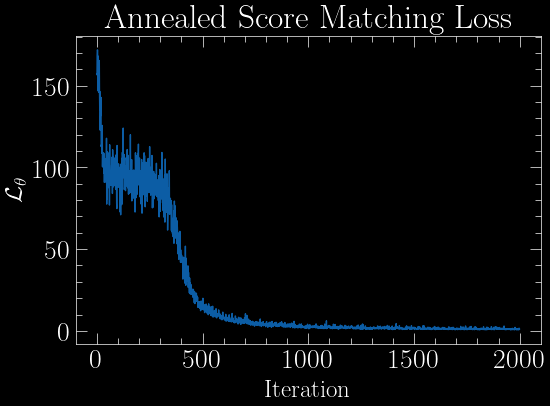

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title("Annealed Score Matching Loss")
plt.ylabel(r"$\mathcal{L}_\theta$")
plt.xlabel("Iteration");

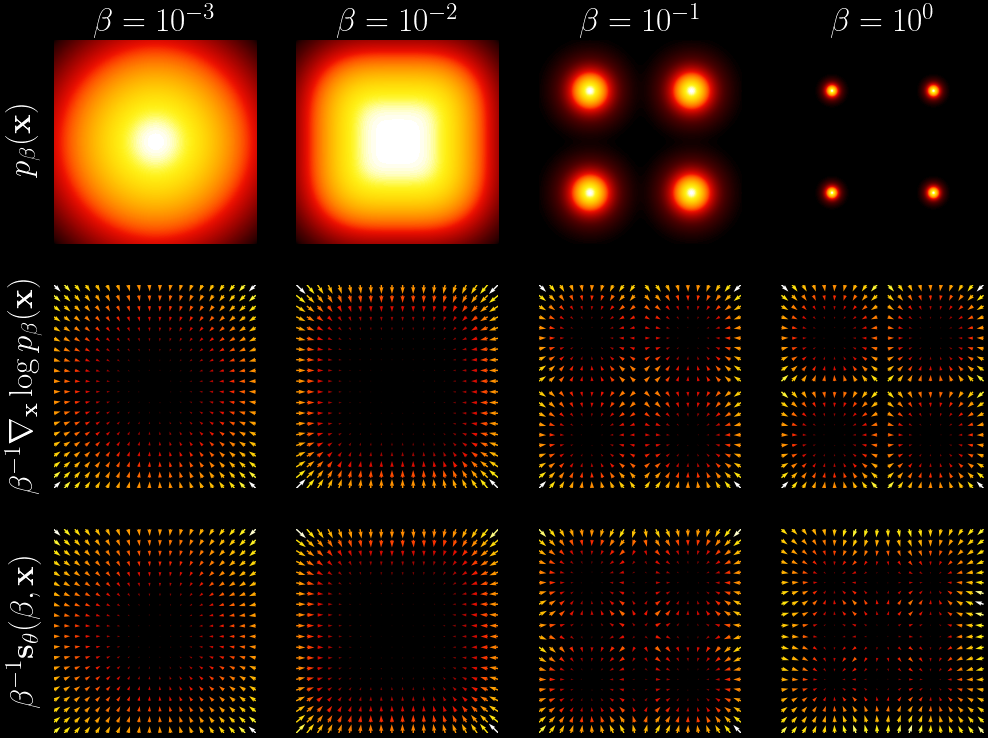

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)
extent = (-2, 2, -2, 2)

for i in range(4):
    beta = [1e-3, 1e-2, 1e-1, 1.][i]
    ax = axs[0, i]
    plot_density(annealed_egg_box(beta).log_prob, ax=ax, extent=extent)
    ax.set_title(r"$\beta = 10^{%d}$" % np.log10(beta))
    ax.axis("off")

    ax = axs[1, i]
    score_fn = lambda x: annealed_score(torch.tensor([beta]).repeat(x.shape[0]), x)/beta
    plot_score(score_fn, ax=ax, extent=extent)
    ax.axis("off")

    ax = axs[2, i]
    score_fn = lambda x: net(torch.tensor([beta]).repeat(x.shape[0]), x)/beta**(1/2)
    plot_score(score_fn, ax=ax, extent=extent)
    ax.axis("off");
axs[0, 0].annotate(r"$p_{\beta}(\mathbf{x})$", (-0.15, 0.5), 
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24)
axs[1, 0].annotate(r"$\beta^{-1}\nabla_{\mathbf{x}} \log p_{\beta}(\mathbf{x})$", (-0.15, 0.5), 
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24)
axs[2, 0].annotate(r"$\beta^{-1}\mathbf{s}_\theta(\beta, \mathbf{x})$", (-0.15, 0.5),
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24);

Not so bad. The model is able to accurately capture the score for a wide range of values for $\beta$. It is also much more precise in regions of low density compared to our previous attempts. 

Unfortunately, the score at $\beta = 1$ is still not quite correct in regions of low density. As it turns out, we don't need to worry about this. But it's a good thing to keep in mind. It's rather tricky to get the score to be globally accurate at $\beta = 1$. In practice, there might be specific choices for the sampling distribution or the weight $\lambda(\beta)$ that alleviate this problem. We will not explore this here.

## Denoising Score Matching (DSM)

We now address how to make this procedure work when we don't have access to the target score function. We need to construct a score matching procedure that do not make use of any knowledge about the actual distribution. This procedure was discovered by [Pascal Vincent in 2011](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf). But first, let's describe the setup. In practice, we are given access to a dataset with $N$ samples

$$
    \mathcal{D} = \{\mathbf{x}^{(i)}\}_{i=1}^N
$$
We make the assumption that the samples are independently and identically distributed (iid) according to a law $p(\mathbf{x})$. Empirically, the law described by the samples is a sum of Dirac deltas

$$
    p(\mathbf{x}) = \sum_{i=1}^N \delta^{(n)}(\mathbf{x} - \mathbf{x}^{(i)})
$$
Naturally, this description gets better as $N \rightarrow \infty$. Also, notice the similarity between this empirical description and the annealed distribution as $\beta \rightarrow \infty$. Working with samples instead of a distribution is simply a shift in perspective, starting at $\beta = \infty$ instead $\beta = 1$.

### Annealing by adding noise

To anneal this distribution, we will be adding noise to the samples in our dataset. Let $\mathbf{x}_0 \sim \mathcal{D}$ be a sample from the dataset. We define $\mathbf{x}_t$ to be a noisy or perturbed version of $\mathbf{x}_0$. $\mathbf{x}_t$ is sampled from the Gaussian perturbation kernel $\mathbf{x}_t \sim p(\mathbf{x}_t \mid \mathbf{x}_0)$, where

$$
    p(\mathbf{x}_t \mid \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t \mid \mathbf{x}_0, \sigma^2(t))\, .
$$
Another way to parametrize this perturbation is to make use of an auxiliary random variable $\mathbf{z} \sim \mathcal{N}(\mathbf{z} \mid 0, 1)$:

$$
    \mathbf{x}_t = \mathbf{x}_0 + \sigma(t) \mathbf{z}
$$
We use the time-index $t$ to label the different levels of noise, $\sigma(t)$. The time-index $t$ plays the role of $\beta$ in indexing the distributions. $t$ is much more convenient than $\beta$ since the empirical distribution corresponds to $t = 0$ instead of $\beta = \infty$. The sequence of noise levels is a monotically increasing sequence, for which $t$ is a natural index

$$
    t_1 < t_2 \implies \sigma(t_1) < \sigma(t_2)
$$
To connect with the previous section, let's work out what the annealed distribution is. Let's write $p_t(\mathbf{x}_t)$ in terms of the empirical distribution $p(\mathbf{x}_0)$ and the Gaussian perturbation kernel $p(\mathbf{x}_t \mid \mathbf{x}_0)$

$$
\begin{align*}
    p_t(\mathbf{x}_t) &= \int_\mathcal{X} p(\mathbf{x}_0) p(\mathbf{x}_t \mid \mathbf{x}_0)\, \mathrm{d}^n \mathbf{x}_0 \\
                    &= \int_\mathcal{X} \sum_{i=1}^N \delta^{(n)}(\mathbf{x}_0 - \mathbf{x}^{(i)}_0)p(\mathbf{x}_t \mid \mathbf{x}_0)\, \mathrm{d}^n \mathbf{x}_0 \\
                    &= \sum_{i=1}^N p(\mathbf{x}_t \mid \mathbf{x}^{(i)}_0) \\
                    &= \sum_{i=1}^N \mathcal{N}(\mathbf{x}_t \mid \mathbf{x}_0^{(i)}, \sigma^2(t))
\end{align*}
$$
What this tells us is that adding noise to samples from the empirical distribution produces an annealed distribution, $p_t(\mathbf{x}_t)$, which is a mixture of Gaussian modes around each samples from the dataset. 
The width of these modes is increased as a function of $t$. This is analogous to how our previous example was annealed by decreasing values of $\beta$. 

### DSM equivalence with SM

Using the empirical description above leads to a problem in our current score matching (SM) formulation. 
Let's recall the SM loss, now written in terms of $t$ instead of $\beta$

$$
    \mathcal{L}^{\mathrm{SM}}_\theta = \mathbb{E}_{p(t)}\mathbb{E}_{p_t(\mathbf{x}_t)}
    \bigg[
        \lambda(t)\big\lVert \mathbf{s}_\theta(t, \mathbf{x}_t) - \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t) \big\rVert^2_2
    \bigg]
$$
Our empirical description for the target score of $p_t(\mathbf{x}_t)$ is defined as a sum over the entire dataset $\mathcal{D}$. In practice, a dataset is often too large to fit into the fast-access memory of the hardware used to train the neural network model. Typical datasets with images can easily contain from $10\, \mathrm{GB}$ to more than $1\, \mathrm{TB}$ of data. 
In the future, hardware could perhaps handle this situation. But, to my knowledge, current GPUs can only deal with $\mathcal{O}(10)\, \mathrm{GB}$ of VRAM &mdash; the largest being the H100 GPU with $\sim 80\, \mathrm{GB}$ of VRAM. Of course, GPUs can be connected to increase the memory. But let's not consider this here. It makes the challenge overly complicated, and there is a rather simple solution to our predicament. 

[P. Vincent (2011)](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf) defined a loss function completely equivalent to the one above with a clever manipulation. The argument goes as follows. First, develop the squared norm and collect every terms that do not depend on $\theta$ in a constant, $C$. This constant represent all terms that do not impact the learning problem, specifically those that do not depend on $\theta$. Indeed, minimizing $\mathcal{L}_\theta$ w.r.t. $\theta$ involves taking the gradient $\nabla_\theta$, which will make all such terms vanish. 

$$
    \mathcal{L}^{\mathrm{SM}}_\theta = \mathbb{E}_{p(t)}\mathbb{E}_{p_t(\mathbf{x}_t)}
    \bigg[
        \lambda(t)\big\lVert \mathbf{s}_\theta(t, \mathbf{x}_t) \big\rVert^2_2
        - 2\lambda(t) \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t) 
    \bigg]
    + C
$$

Let's isolate the second term and develop it, ignoring multiplicative factors and the expectation over $t$

$$
    \begin{align*}
        \mathbb{E}_{p_t(\mathbf{x}_t)}
            \bigg[ 
                 \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)
            \bigg]
            &= 
             \int_{\mathbf{x}_t} \, p_t(\mathbf{x}_t)
            \,
            \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)  \\
            &= 
             \int_{\mathbf{x}_t} \, p_t(\mathbf{x}_t)
            \,
            \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot \frac{1}{p_t(\mathbf{x}_t)}\nabla_{\mathbf{x}_t} p_t(\mathbf{x}_t)  \\
            &= 
              \int_{\mathbf{x}_t}
            \,
            \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot \nabla_{\mathbf{x}_t} \int_{\mathbf{x}_0} p_t(\mathbf{x}_t, \mathbf{x}_0)\\
            &= 
              \int_{\mathbf{x}_t}
            \,
            \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot \nabla_{\mathbf{x}_t}  \int_{\mathbf{x}_0} p_0(\mathbf{x}_0)  p(\mathbf{x}_t \mid \mathbf{x}_0)\\
            &= 
             \int_{\mathbf{x}_t}
            \,
            \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot \int_{\mathbf{x}_0} p_0(\mathbf{x}_0) p(\mathbf{x}_t \mid \mathbf{x}_0) 
            \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t \mid \mathbf{x}_0)  \\
            &= 
             \int_{\mathbf{x}_t}\int_{\mathbf{x}_0} p(\mathbf{x}_t ,\mathbf{x}_0) 
            \,
            \bigg[ 
            \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot 
            \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t \mid \mathbf{x}_0) \bigg] \\
            &= 
            \mathbb{E}_{p(\mathbf{x}_t, \mathbf{x}_0)} \bigg[ 
            \,
            \mathbf{s}_\theta(t, \mathbf{x}_t) \cdot 
            \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t \mid \mathbf{x}_0) \bigg] \\
    \end{align*}
$$
Now, inserting this term back into the previous expression and completing the square, we obtain a new objective

$$
    \mathcal{L}^{\mathrm{DSM}}_\theta = \mathbb{E}_{p(t)}\mathbb{E}_{p(\mathbf{x}_t, \mathbf{x}_0)}
    \bigg[
        \big\lVert 
            \mathbf{s}_\theta(t, \mathbf{x}_t) - \nabla_{x_t} \log p(\mathbf{x}_t \mid \mathbf{x}_0)
        \big\rVert^2_2
    \bigg]\, .
$$
Both objectives yield the same score function $\mathbf{s}_{\theta^\star}(t, \mathbf{x}_t)$ at their optimum $\theta^\star$. But this new objective is vastly more efficient because it makes use only of $\nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t \mid \mathbf{x}_0)$, and not $\nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)$. Indeed, $p_t(\mathbf{x}_t)$ is often intractable, whereas the Gaussian perturbation kernel is trivial to evaluate. Its score is

$$
    \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t \mid \mathbf{x}_0) = - \frac{\mathbf{x}_t - \mathbf{x}_0}{\sigma^2(t)}\, .
$$
We can also use an auxiliary variable to reparametrize $\mathbf{x}_t = \mathbf{x}_0 + \sigma(t)\mathbf{z}$. The score then becomes

$$
    \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t \mid \mathbf{x}_0) = - \frac{\mathbf{z}}{\sigma(t)}\, .
$$

After we redefine the score function to make the learning problem easier for the neural network

$$
    \mathbf{s}_\theta(t, \mathbf{x}_t) \equiv \frac{\boldsymbol{\epsilon}_\theta(t, \mathbf{x}_t)}{\sigma(t)}\, ,
$$
the loss function becomes &mdash; setting $\lambda(t) = \sigma(t)$ as the weight

$$
    \mathcal{L}_\theta^{\mathrm{DSM}} = 
    \mathbb{E}_{p(t)}\mathbb{E}_{p(\mathbf{z}, \mathbf{x}_0)}
    \bigg[
        \big\lVert 
            \boldsymbol{\epsilon}_\theta\big(t, \mathbf{x}_0 + \sigma(t) \mathbf{z}\big) + \mathbf{z}
        \big\rVert^2_2
    \bigg]\, .
$$
This is what we'll use in practice. We can also choose $p(t) = \mathcal{U}(0, 1)$. Of course we need to set a noise schedule. Let's use a geometric progression, which is set such that it interpolates between two chosen value, $\sigma_{\max/\min}$

$$
    \sigma(t) = \sigma_{\min} \left( \frac{\sigma_{\max}}{\sigma_{\min}}\right)^t\, .
$$
Naturaly, the choice for $\lambda(t)$, $p(t)$ and $\sigma(t)$ all seem arbitrary. And to some degree they are. But I explain in more detail the reasoning and theory behind them in the section discussing [SDEs](./04-sdes.ipynb) alongside the pioneering works of Yang Song, Jonathan Ho and many others.

### DSM in practice

One thing about DSM that can be confusing at first is the behavior of the loss function. Don't try to read too much into it. The loss function is not supposed to reach 0. And it is normal that it oscillates a lot. To compensate for this, we use a neat technique. Instead of saving the weights $\theta$ of the neural network after a number of iterations, we save the exponential moving average (EMA) of the weight over the training.

Here is little FAQ:

**Q**: Should I split the dataset into a training and validation set?
**A**: No. The goal of training an SBM is to encode an empirical distribution defined by your samples. The concept of the generalization error is ill-defined in this setting. 

**Q**: The loss has plateaued, should I stop training? **A**: No. The neural network is still learning, even while the loss reaches a plateau. Keep training with a constant learning rate for as long as you can afford it.

In [14]:
D = int(1e3)  # Number of samples in the dataset
# distribution = egg_box(4, mode_width=0.1, box_size=1)
distribution = swiss_roll()
# distribution = two_moons()
dataset = distribution.sample((D,))

In [15]:
sigma_min = 1e-2
sigma_max = 5
def sigma(t):
    return sigma_min * (sigma_max / sigma_min) ** t

In [16]:
def dsm_loss(t, x, epsilon):
    z = torch.randn_like(x)
    xt = x + sigma(t).view(-1, 1) * z
    return ((epsilon(t, xt) + z) ** 2).flatten(1).sum(1).mean()

In [30]:
from torch_ema import ExponentialMovingAverage
N = int(2e4)  # Number of iterations
B = int(2**8) # Batch size
net = Epsilon(2)
optim = torch.optim.Adam(net.parameters(), lr=3e-4)
ema = ExponentialMovingAverage(net.parameters(), decay=0.999)

losses = []
for i in tqdm(range(N)):
    t = torch.rand(B)                              # t ~ U(0, 1)
    idx = np.random.choice(D, B, replace=False)
    x = dataset[idx]                               # x ~ D 
    loss = dsm_loss(t, x, net)                     # loss = E_{t, x} [||∇\epsilon(t, x + σ(t)z) + z||^2]
    optim.zero_grad()
    loss.backward()
    optim.step()
    ema.update()
    losses.append(loss.item())
ema.copy_to(net.parameters()) # Copy the EMA parameters back to the model

  0%|          | 0/20000 [00:00<?, ?it/s]

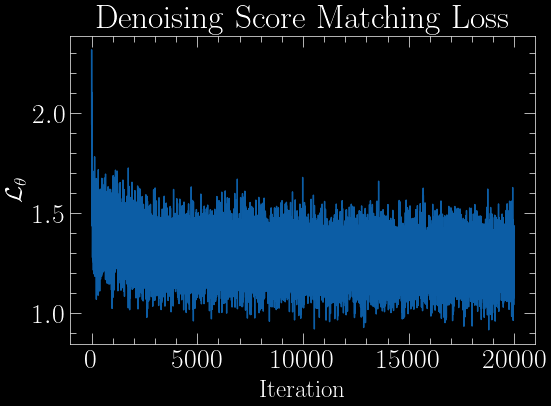

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title("Denoising Score Matching Loss")
plt.ylabel(r"$\mathcal{L}_\theta$")
plt.xlabel("Iteration");

We can compare our model against the annealed empirical distribution. Remember that

$$
    p_t(\mathbf{x}_t) = \sum_{i=1}^N \mathcal{N}(\mathbf{x}_t \mid \mathbf{x}_0^{(i)}, \sigma^2(t))\, ,
$$
where $\mathbf{x}_0^{(i)} \in \mathcal{D}$. 

In [32]:
def annealed_empirical_distribution_logp(t, x, dataset=dataset):
    # Technically, this is proportional to logp. I didn't bother to write the normalization constant
    energy = ((x.view(1, -1) - dataset)**2).sum(1) / (2 * sigma(t)**2)
    return torch.logsumexp(-energy, 0)
    

def annealed_empirical_distribution_score(t, x):
    return vmap(grad(annealed_empirical_distribution_logp, argnums=1))(t, x)

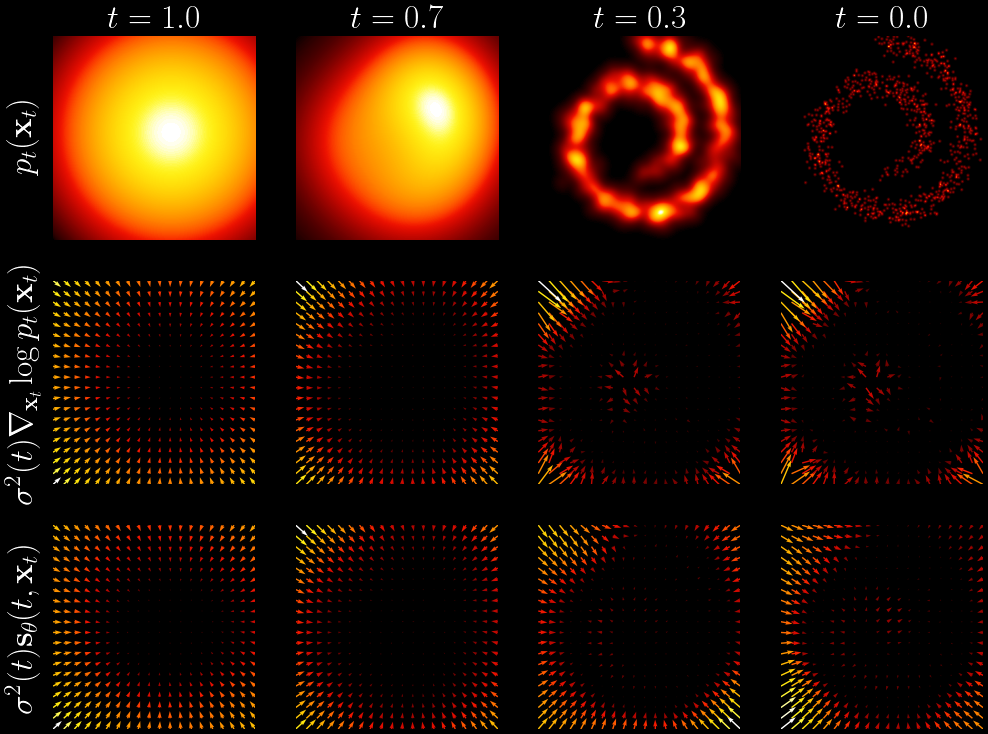

In [33]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)
extent = (-1.5, 1.5, -1.5, 1.5)

for i in range(4):
    t = float(np.linspace(0, 1, 4)[::-1][i])
    ax = axs[0, i]
    logp_fn = lambda x: vmap(annealed_empirical_distribution_logp)(torch.tensor([t]).repeat(x.shape[0]), x)
    plot_density(logp_fn, ax=ax, extent=extent)
    ax.set_title(r"$t = %.1f$" % t)
    ax.axis("off")

    ax = axs[1, i]
    score_fn = lambda x: annealed_empirical_distribution_score(torch.tensor([t]).repeat(x.shape[0]), x) * sigma(t)**2
    plot_score(score_fn, ax=ax, extent=extent, scale=None)
    ax.axis("off")

    ax = axs[2, i]
    score_fn = lambda x: net(torch.tensor([t]).repeat(x.shape[0]), x) * sigma(t)
    plot_score(score_fn, ax=ax, extent=extent, scale=None)
    ax.axis("off");
axs[0, 0].annotate(r"$p_{t}(\mathbf{x}_t)$", (-0.15, 0.5), 
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24)
axs[1, 0].annotate(r"$\sigma^2(t)\nabla_{\mathbf{x}_t} \log p_{t}(\mathbf{x}_t)$", (-0.15, 0.5), 
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24)
axs[2, 0].annotate(r"$\sigma^2(t)\mathbf{s}_\theta(t, \mathbf{x}_t)$", (-0.15, 0.5),
    xycoords="axes fraction", va="center", ha="center", rotation=90, fontsize=24);